## 3. Extract cutout images

We import the necessary packages and set the default afwDisplay backend

In [2]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb
import gc
import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service
import lsst.geom as geom
afwDisplay.setDefaultBackend('matplotlib')

### 3.1 Function definition
We can define a function that, given coordinates, a length and a data id, can extract a cutout.

In [15]:
def cutout_coadd(butler, ra, dec, dataId, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Helper object providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the calexp's visit
    detector: int
        Detector for the calexp
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    
    #dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)
    #print(cutoutSize)
    calexp_wcs = butler.get('deepCoadd_calexp.wcs', **dataId)
    #print(calexp_wcs)
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    #print("xy:"+str(xy))
    # bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    #print(bbox)
    parameters = {'bbox': bbox}
    #print(parameters)
    cutout_image = butler.get('deepCoadd_calexp.image', parameters=parameters, **dataId)
    #cutout_image=0
    return cutout_image

Again, we instanciate a butler for a particular collection:

In [6]:
video='u/ir-shir1/DRP/videoCoaddDetect/20221130T131608Z'
butler = Butler('/data/butler/dmu4', collections=video)

And retrieve a coadd image

In [7]:
my_deepCoadd_H = butler.get('deepCoadd_calexp.image', band='H', tract=8525, patch=70, skymap='hscPdr2')

We define the function to do the cleaning

In [10]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint. 
    This function was taken from the notebook DP02_03a at data.lsst.cloud

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

And check that we can plot the image that we have just retrieved.

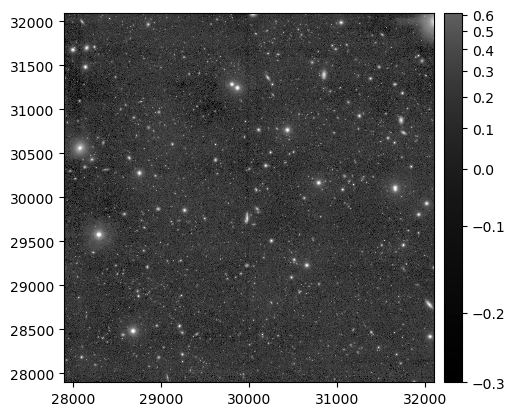

In [11]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(my_deepCoadd_H.image)
plt.show()
#remove_figure(fig)

In a science use case, we may already know the coordinates for whatever object we are interested in, but for this case, we can choose pixels according to what is displayed in the image above.

In [12]:
dataId={'band':'H','tract':8525,'patch':70}
wcs=my_deepCoadd_H.getWcs()
print(wcs)

FITS standard SkyWcs:
Sky Origin: (37.1900826446, -5.2066115702)
Pixel Origin: (17999, 17999)
Pixel Scale: 0.168 arcsec/pixel


In [13]:
radec = wcs.pixelToSky(28250,29600)
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
print(ra, dec)

36.710145106705816 -4.665084734474732


We can now use the coordinates we retrieved to create a cutout:

In [14]:
my_cutout_coadd_H = cutout_coadd(butler, ra, dec, dataId,cutoutSideLength=200)

(200, 200)
FITS standard SkyWcs:
Sky Origin: (37.1900826446, -5.2066115702)
Pixel Origin: (17999, 17999)
Pixel Scale: 0.168 arcsec/pixel
xy:(28250, 29600)
(minimum=(28150, 29500), maximum=(28349, 29699))
{'bbox': Box2I(corner=Point2I(28150, 29500), dimensions=Extent2I(200, 200))}


And we plot the cutout

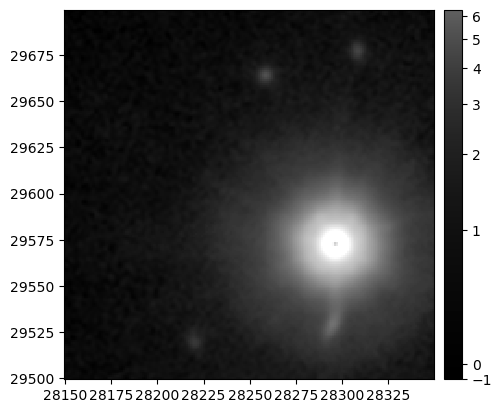

In [16]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(my_cutout_coadd_H.image)
plt.show()
remove_figure(fig)